In [40]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

learning_rate = tf.Variable(0.0001)
batch_size = 256
hidden_size = 128
z_size = 100
x2_size = 784
x1_size = 10
dropout = 0.5
is_training = True
#read data
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

xavier_init = tf.contrib.layers.xavier_initializer()

def fullLayer(input_data, output_size, act, name):
    w = tf.Variable(xavier_init([input_data.get_shape().as_list()[1], output_size]), name = name + "_weigth")
    b = tf.Variable(tf.zeros([output_size]), name = name + "_bias")
    return act(tf.matmul(input_data, w) + b)

def leakyRelu(x, alpha = 0.1):
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

x2 = tf.placeholder(tf.float32, [None, x2_size], name='x2')
x1 = tf.placeholder(tf.float32, [None, x1_size], name='x1')
z = tf.placeholder(tf.float32, [None, z_size], name='z')

with tf.variable_scope("generator"):
    w_gen_hidden = tf.Variable(xavier_init([z_size + x1_size, hidden_size]), name = "w_gen_hidden")
    b_gen_hidden = tf.Variable(tf.zeros([hidden_size]), name = "b_gen_hidden")
    
    w_gen_result = tf.Variable(xavier_init([hidden_size, x2_size]), name = "w_gen_result")
    b_gen_result = tf.Variable(tf.zeros([x2_size]), name = "b_gen_result")
    
    gen_hidden = leakyRelu(tf.matmul(tf.concat((z, x1), axis = 1), w_gen_hidden) + b_gen_hidden)
    gen_hidden_dropout = tf.layers.dropout(gen_hidden, rate=dropout, training=is_training)
    fake_x = tf.nn.sigmoid(tf.matmul(gen_hidden_dropout, w_gen_result) + b_gen_result)
    
    G_params = [w_gen_hidden, b_gen_hidden, w_gen_result, b_gen_result]


with tf.variable_scope("discriminator"):
    w_dis_hidden = tf.Variable(xavier_init([x2_size + x1_size, hidden_size]), name = "w_dis_hidden")
    b_dis_hidden = tf.Variable(tf.zeros([hidden_size]), name = "b_dis_hidden")
    
    w_result = tf.Variable(xavier_init([hidden_size, 1]), name = "w_dis_result")
    b_result = tf.Variable(tf.zeros([1]), name = "b_dis_result")
    
    dis_hidden_fake = leakyRelu(tf.matmul(tf.concat((fake_x,x1), axis = 1), w_dis_hidden) + b_dis_hidden)
    fake_result = tf.nn.sigmoid(tf.matmul(dis_hidden_fake , w_result) + b_result)
    
    dis_hidden_true = leakyRelu(tf.matmul(tf.concat((x2,x1), axis = 1), w_dis_hidden) + b_dis_hidden)
    true_result = tf.nn.sigmoid(tf.matmul(dis_hidden_true , w_result) + b_result)
    
    D_params = [w_dis_hidden, b_dis_hidden, w_result, b_result]
    

with tf.variable_scope("loss"):
    discriminator_loss = -tf.reduce_mean(tf.log(true_result+ 1e-20) + tf.log(1- fake_result + 1e-20))
    generator_loss = -tf.reduce_mean(tf.log(fake_result+ 1e-20))
    

with tf.variable_scope("optimizer_init"):
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(discriminator_loss, var_list = D_params)
    generator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list = G_params)
    init = tf.global_variables_initializer()


Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [31]:
print(1000000 / mnist.train.num_examples * 20)

363.6363636363637


In [ ]:
import time

n_epochs = 300
k = 1


#just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)

sess = tf.Session(config = config)
##starting time
start_time = time.time()
##initialize the variables
sess.run(init)

## number of training batches
n_batches = int(mnist.train.num_examples / batch_size / (k+1))

for i in range(n_epochs):  # train the model n_epochs times
    total_generator_loss = 0
    total_discriminator_loss = 0
    for b in range(n_batches):
        
        ##training discriminator
        for j in range(k):
            z1 = np.random.normal(0, 1.0, [batch_size, z_size])
            
            x2_batch, x1_batch = mnist.train.next_batch(batch_size)
            _, loss_batch = sess.run([discriminator_optimizer, discriminator_loss], feed_dict={x1: x1_batch, x2: x2_batch, z:z1})
            total_discriminator_loss += loss_batch
            
        ##training generator
        mean = np.zeros(z_size)
        cov = np.eye(z_size)
        z1 = np.random.multivariate_normal(mean, cov, batch_size)
                                           
        x2_batch, x1_batch = mnist.train.next_batch(batch_size)
        _, loss_batch = sess.run([generator_optimizer, generator_loss], feed_dict={x1: x1_batch, x2: x2_batch, z:z1})
        total_generator_loss += loss_batch
        
    print('epoch {}, Average discriminator loss : {}, Average generator loss : {}'.format(i, total_discriminator_loss / k/n_batches, total_generator_loss / n_batches))
            
print('Total time: {0} seconds'.format(time.time() - start_time))
print('Optimization Finished!')


epoch 0, Average discriminator loss : 0.43792937514937924, Average generator loss : 2.9253370539050234
epoch 1, Average discriminator loss : 0.4909826316566111, Average generator loss : 2.8299385409488855
epoch 2, Average discriminator loss : 0.43553841309012653, Average generator loss : 2.9531683587582314
epoch 3, Average discriminator loss : 0.37173235277149164, Average generator loss : 3.1630452592796257
epoch 4, Average discriminator loss : 0.3626415868785894, Average generator loss : 3.1960224325411786
epoch 5, Average discriminator loss : 0.36867624075613287, Average generator loss : 3.1069739176848223
epoch 6, Average discriminator loss : 0.43315851939058747, Average generator loss : 2.9585963097688195
epoch 7, Average discriminator loss : 0.5322633196260328, Average generator loss : 2.727861150402889
epoch 8, Average discriminator loss : 0.39366659048561736, Average generator loss : 3.074758892861482
epoch 9, Average discriminator loss : 0.3920270343807256, Average generator lo

In [ ]:
def to_one_hat(x):
    out = np.zeros((len(x), 10))
    for i, a in enumerate(x):
        out[i, a] = 1
    return out

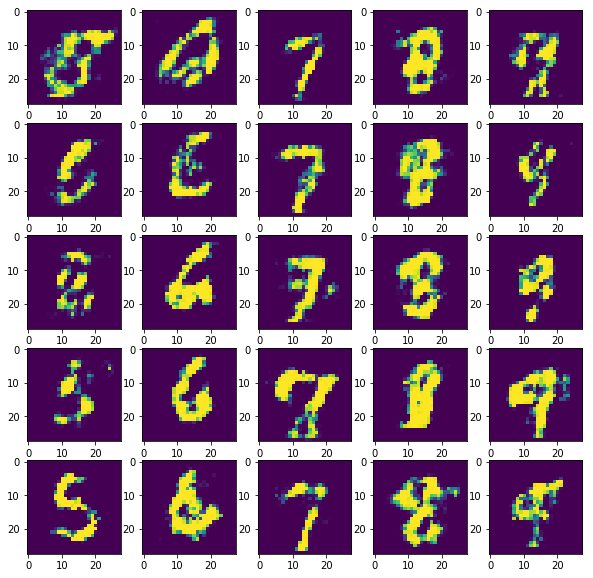

In [49]:
import matplotlib.pyplot as plt

z1 = np.random.normal(0, 1.0, [25, z_size])

x1_batch = [i for i in range(5,10)] * 5
x1_batch = to_one_hat(x1_batch)

fake = sess.run([fake_x], feed_dict={x1: x1_batch, z:z1})
fake = fake[0]
total_discriminator_loss += loss_batch

fig, axes = plt.subplots(5, 5, figsize = (10,10))
for i in range(25):
    im = fake[i, :]
    axes[i // 5, i % 5].imshow(im.reshape(28,28))
plt.show()

In [50]:
sess.close()